# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [34]:
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [27]:
 combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [26]:
print(combined_columns)

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)


In [24]:
pd.set_option('display.max_columns', None)

In [28]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

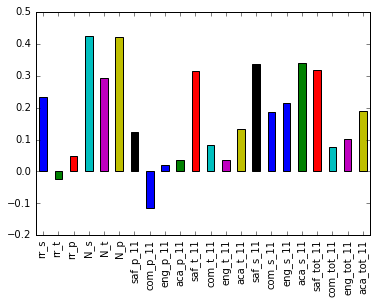

In [49]:
combined.corr()['sat_score'][survey_fields].plot.bar()

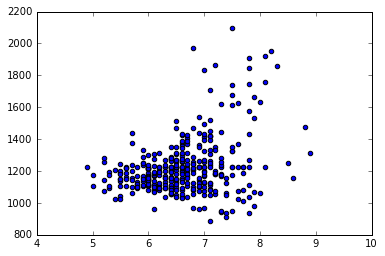

In [46]:
plt.scatter(combined.saf_s_11, combined.sat_score)

# Hight saftey score has higher SAT Score.

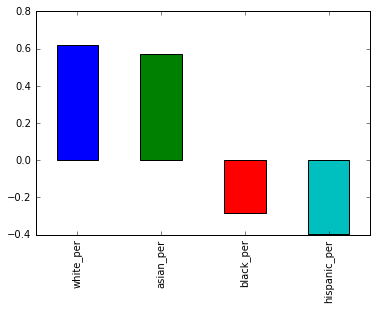

In [54]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()['sat_score'][race_fields].plot.bar()

# White and Asian has higher SAT vs Blacks and Hispanic

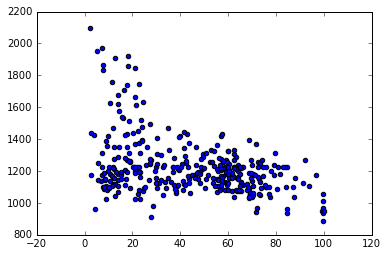

In [55]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])


In [56]:
hispanic_schools = combined[combined['hispanic_per'] > 95]

In [57]:
hispanic_schools

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,59.00,Total Cohort,MANHATTAN BRIDGES HIGH SCHOOL,2006,111.000000,77,69.400000000000006%,63,56.8%,81.8%,16,14.4%,20.8%,47,42.3%,61%,14,12.6%,18.2%,17,15.3%,15,13.5%,2,107.187500,4.375000,23.475000,19.187500,26.937500,0.0,MANHATTAN BRIDGES HIGH SCHOOL,20112012,0,83.5,541,,,,,,,,,,,149,168,138,86,393.0,72.6,9.0,1.7,0,5,1,0.2,0,0.0,540,99.8,0,0.0,278.0,51.4,263.0,48.6,94.0,100,83,480.0,37.0,396.0,8.8,8.2,7.6,8.4,7.6,6.6,7.5,8.2,7.2,6.2,6.7,7.5,7.9,7.0,7.3,8.0,02M542,Manhattan Bridges High School,Manhattan,M535,212-757-5274,212-757-5411,9,12,0,12.0,"M104, M11, M31, M34A-SBS, M42, M50, M57","C, E to 50th St",525 West 50Th Street,New York,NY,10019,manhattanbridges.org,552.0,Park West Educational Campus,0,We are a New Visions School founded on the bel...,"College Now, National Academy Foundation, Acad...",Spanish,"Calculus AB, English Language and Composition,...",0,0,"Academic Intervention Services (Extended Day),...","Baseball, Basketball & JV Basketball, Bowling,...","Baseball, Bowling, Handball, Soccer, Tennis, V...","Bowling, Tennis","Running Club, Workout Club",The Young Men and Women Hebrew Association (YM...,"St. Vincent's Hospital, New York-Presbyterian ...","Cornell University, Columbia University, Roche...","El Museo del Barrio, Carnegie Hall, Metropolit...","New Visions for Public Schools, National Acade...","Latin Vision Media, Urban Latino Magazine Inc....","Chase Manhattan Bank, Bank of America","Manhattan District Attorney's Office, New York...","Dress Code Required: white shirt/blouse, black...","Community Service Requirement, Extended Day Pr...",8:00 AM,3:45 PM,This school will provide students with disabil...,ESL; Dual Language: Spanish; Transitional Bili

In [58]:
hispanic_schools = combined[combined['hispanic_per'] < 10]

In [59]:
hispanic_schools

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.000000,735.000000,682.000000,2096.000000,STUYVESANT HS,1510.000000,2819.000000,2648.00,Total Cohort,STUYVESANT HIGH SCHOOL,2006,787.000000,774,98.3%,774,98.3%,100%,770,97.8%,99.5%,4,0.5%,0.5%,0,0%,0%,10,1.3%,3,0.4%,2,876.052632,28.000000,31.115789,24.105263,33.842105,0.0,STUYVESANT HIGH SCHOOL,20112012,0,30.3,3297,,,,,,,,,,,813,827,848,809,0.0,0.0,14.0,0.4,0,0,2377,72.1,40,1.2,80,2.4,780,23.7,1956.0,59.3,1341.0,40.7,93.0,95,33,3039.000000,161.0,1062.0,8.4,7.5,7.7,7.7,7.2,5.6,6.1,7.2,7.500000,6.200000,7.000000,7.900000,7.7,6.4,6.9,7.6,02M475,Stuyvesant High School,Manhattan,M477,212-312-4800,212-587-3874,9,12,0,12.0,"M20, M22, M5, M9, S1115","1, 2, 3, A, C, E to Chambers St ; R to City Hall",345 Chambers Street,New York,NY,10282,http://stuy.edu,3292.0,0,Specialized School,Our goal is to provide our students with the b...,Mentoring in Intel Science Program through pro...,"Chinese (Mandarin), French, German, Italian, J...","Biology, Calculus AB, Calculus BC, Chemistry, ...",0,0,"Accelerated courses, Student Union, Yearly pub...","Baseball & JV Baseball, Basketball & JV Basket...","Basketball, Bowling, Cross Country, Fencing, G...",Cricket,0,0,"Bellevue Hospital Center, New York-Presbyteria...","New York Law School, New York University (NYU)...",0,"American Red Cross, UNICEF, American Cancer So...",0,"Citicorp, Goldman Sachs",Explorer Program,This is one of New York City's eight (8) Speci...,0,8:00 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Open to New York City residents,0,0,0,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
46,02M545,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,78,412.000000,581.000000,431.000000,1424.000000,High School for Dual Language a

In [60]:
gender_cols = ['male_per','female_per']

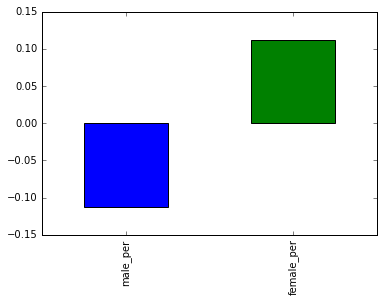

In [62]:
combined.corr()['sat_score'][gender_cols].plot.bar()

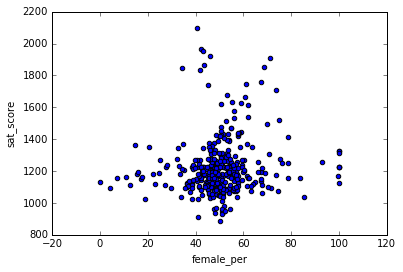

In [64]:
combined.plot.scatter('female_per', 'sat_score')

In [69]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [73]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

In [76]:
ap_per

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
5      0.209123
6      0.741545
7      0.297988
8      0.376177
9      0.307945
10     0.050725
11     0.229698
12     0.093126
13     0.080128
14     0.384014
15     0.341346
16     0.260664
17     0.297988
18     0.388641
19     0.424437
20     0.528807
21     0.152798
22     0.039841
23     0.180556
24     0.196891
25     0.295938
26     0.305720
27     0.137380
28     0.306482
29     0.115385
         ...   
333    0.029536
334    0.084567
335    0.877747
336    0.053398
337    0.268251
338    0.260664
339    0.307945
340    0.082513
341    0.119905
342    0.142857
343    0.055616
344    0.127682
345    0.143466
346    0.293247
347    0.242535
348    0.316247
349    0.123853
350    0.036117
351    0.090191
352    0.096787
353    0.102194
354    0.086031
355    0.191154
356    0.478261
357    0.356433
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Length: 363, dtype: floa

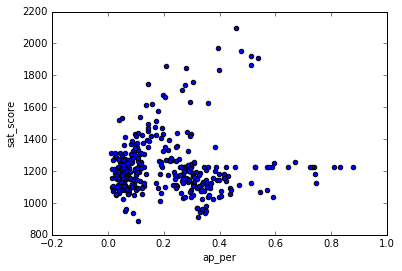

In [79]:
combined.plot.scatter('ap_per', 'sat_score')